In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense, ReLU
import tensorflow as tf

# Suppress TensorFlow logging
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
pd.options.mode.chained_assignment = None  # Suppress warnings for chained assignment
np.random.seed(100)


In [ ]:
# Load the dataset
myData = pd.read_csv("/content/heart.csv")

# Rename the columns
myData.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol',
                  'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved', 'exercise_induced_angina',
                  'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

# Replace categorical variables with more readable names
myData['sex'] = myData['sex'].replace({0: 'female', 1: 'male'})
myData['chest_pain_type'] = myData['chest_pain_type'].replace({1: 'typical angina', 2: 'atypical angina', 3: 'non-anginal pain', 4: 'asymptomatic'})
myData['fasting_blood_sugar'] = myData['fasting_blood_sugar'].replace({0: 'lower than 120mg/ml', 1: 'greater than 120mg/ml'})
myData['rest_ecg'] = myData['rest_ecg'].replace({0: 'normal', 1: 'ST-T wave abnormality', 2: 'left ventricular hypertrophy'})
myData['exercise_induced_angina'] = myData['exercise_induced_angina'].replace({0: 'no', 1: 'yes'})
myData['st_slope'] = myData['st_slope'].replace({1: 'upsloping', 2: 'flat', 3: 'downsloping'})
myData['thalassemia'] = myData['thalassemia'].replace({1: 'normal', 2: 'fixed defect', 3: 'reversible defect'})

# One-hot encoding for categorical variables
myData = pd.get_dummies(myData, drop_first=True)

# Identify numeric columns to normalize
numeric_columns = myData.select_dtypes(include=[np.number]).columns

# Normalize only the numeric columns
myData[numeric_columns] = (myData[numeric_columns] - myData[numeric_columns].min()) / (myData[numeric_columns].max() - myData[numeric_columns].min())


In [ ]:
# Split the dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(myData.drop('target', axis=1),
                                                    myData['target'], test_size=.2, random_state=0)


In [ ]:
# Initialize and train various models
models = {
    'Logistic Regression': LogisticRegression(solver='lbfgs'),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(gamma='auto'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

# Train models and print accuracy
for name, model in models.items():
    model.fit(x_train, y_train)
    accuracy = model.score(x_test, y_test)
    print(f"{name} Model Accuracy: {accuracy:.4f}")


Logistic Regression Model Accuracy: 0.8525
KNN Model Accuracy: 0.8361
SVM Model Accuracy: 0.8525
Naive Bayes Model Accuracy: 0.8689
Decision Tree Model Accuracy: 0.7541
Random Forest Model Accuracy: 0.8361


In [ ]:
# Create and train a neural network
nn_model = Sequential()
nn_model.add(Dense(100, input_shape=(x_train.shape[1],), activation='relu'))
nn_model.add(Dense(100, activation='relu'))
nn_model.add(Dense(10, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(x_train, y_train, epochs=15, verbose=0)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Evaluate the neural network
y_predicted = (nn_model.predict(x_test) > 0.5).astype(int)
conf_mat = confusion_matrix(y_test, y_predicted)
print("Confusion Matrix:\n", conf_mat)

# Calculate metrics
total = sum(sum(conf_mat))
sensitivity = conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[1, 0])  # True Positives / (True Positives + False Negatives)
specificity = conf_mat[0, 0] / (conf_mat[0, 0] + conf_mat[0, 1])  # True Negatives / (True Negatives + False Positives)
accuracy = (conf_mat[0, 0] + conf_mat[1, 1]) / total  # (TP + TN) / Total

print(f'Specificity: {specificity:.4f}')
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Accuracy: {accuracy:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Confusion Matrix:
 [[22  5]
 [ 3 31]]
Specificity: 0.8148
Sensitivity: 0.9118
Accuracy: 0.8689


In [ ]:
# Voting classifier implementation
votes = np.zeros(len(y_test))

for model in models.values():
    votes += model.predict(x_test)

votes += (nn_model.predict(x_test) > 0.5).astype(int).flatten()

# Define the voting criteria
majority_votes = votes >= 4  # Majority rule: 4 or more positive votes

# Confusion matrix for voting classifier
conf_mat_voting = confusion_matrix(y_test, majority_votes)
total_votes = sum(sum(conf_mat_voting))
sensitivity_voting = conf_mat_voting[1, 1] / (conf_mat_voting[1, 1] + conf_mat_voting[1, 0])
specificity_voting = conf_mat_voting[0, 0] / (conf_mat_voting[0, 0] + conf_mat_voting[0, 1])
accuracy_voting = (conf_mat_voting[0, 0] + conf_mat_voting[1, 1]) / total_votes

print("\nVoting Classifier Statistics:")
print("Confusion Matrix:\n", conf_mat_voting)
print(f'Specificity: {specificity_voting:.4f}')
print(f'Sensitivity: {sensitivity_voting:.4f}')
print(f'Accuracy: {accuracy_voting:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Voting Classifier Statistics:
Confusion Matrix:
 [[23  4]
 [ 3 31]]
Specificity: 0.8519
Sensitivity: 0.9118
Accuracy: 0.8852


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Load the dataset
myData = pd.read_csv("/content/heart.csv")
myData.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar',
                  'rest_ecg', 'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression',
                  'st_slope', 'num_major_vessels', 'thalassemia', 'target']

# Preprocess the data
# Use .loc[] to avoid chained assignment warning
myData.loc[myData['sex'] == 0, 'sex'] = 'female'
myData.loc[myData['sex'] == 1, 'sex'] = 'male'

# Convert categorical variables to dummy variables
myData = pd.get_dummies(myData, drop_first=True)

# Split the dataset into features and target variable
X = myData.drop('target', axis=1)
y = myData['target']

# Normalize the numerical columns
# Check if there are any non-numeric columns in X and exclude them
X_numeric = X.select_dtypes(include=[np.number])  # Selecting only numeric columns
X_normalized = (X_numeric - X_numeric.min()) / (X_numeric.max() - X_numeric.min())

# Make sure to keep the original DataFrame structure
X[X_numeric.columns] = X_normalized

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define individual classifiers
log_model = LogisticRegression(solver='lbfgs')
knn_model = KNeighborsClassifier()
svm_model = SVC(gamma='auto')
nb_model = GaussianNB()
tree_model = DecisionTreeClassifier()
forest_model = RandomForestClassifier(n_estimators=100)

# Create a Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('logistic', log_model),
    ('knn', knn_model),
    ('svm', svm_model),
    ('nb', nb_model),
    ('tree', tree_model),
    ('forest', forest_model)
], voting='hard')

# Train the Voting Classifier
voting_clf.fit(X_train, y_train)

# Evaluate the model
accuracy = voting_clf.score(X_test, y_test)
print(f"Voting Classifier Accuracy: {accuracy}")

# Confusion Matrix
y_pred = voting_clf.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# Cross-validation
cv_scores = cross_val_score(voting_clf, X, y, cv=5)
print(f"Cross-validation scores: {cv_scores}")


<ipython-input-17-9049d5254626>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'female' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  myData.loc[myData['sex'] == 0, 'sex'] = 'female'


Voting Classifier Accuracy: 0.8852459016393442
Confusion Matrix:
[[26  3]
 [ 4 28]]
Cross-validation scores: [0.85245902 0.8852459  0.80327869 0.86666667 0.76666667]


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression # Import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  # Import KNeighborsClassifier
from sklearn.svm import SVC  # Import SVC

# Define individual classifiers (for example)
classifier1 = LogisticRegression()  # Replace with your classifier
classifier2 = KNeighborsClassifier()  # Replace with your classifier
classifier3 = SVC()  # Replace with your classifier


# Create a Voting Classifier with soft voting
voting_clf = VotingClassifier(
    estimators=[
        ('clf1', classifier1),
        ('clf2', classifier2),
        ('clf3', classifier3)
    ],
    voting='soft'  # Use 'soft' voting to enable predict_proba
)

# Fit the Voting Classifier to the training data
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('clf1', LogisticRegression()),
                             ('clf2', KNeighborsClassifier()),
                             ('clf3', SVC())],
                 voting='soft')

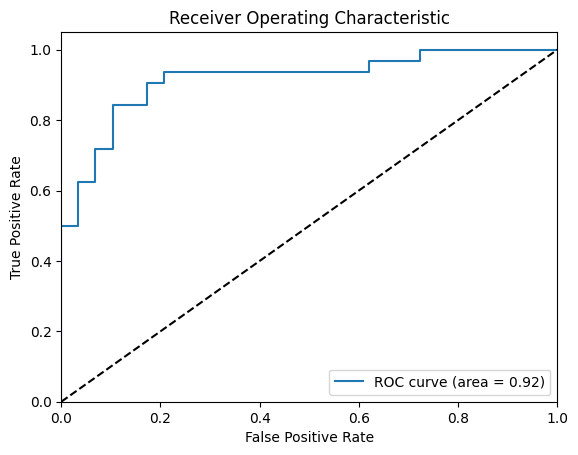

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming voting_clf is your trained VotingClassifier
# and X_test and y_test are your test datasets

# Define individual classifiers (for example)
classifier1 = LogisticRegression()  # Replace with your classifier
classifier2 = KNeighborsClassifier()  # Replace with your classifier
classifier3 = SVC(probability=True)  # Replace with your classifier, enabling probability


# Create a Voting Classifier with soft voting
voting_clf = VotingClassifier(
    estimators=[
        ('clf1', classifier1),
        ('clf2', classifier2),
        ('clf3', classifier3)
    ],
    voting='soft'  # Use 'soft' voting to enable predict_proba
)

# Fit the Voting Classifier to the training data
voting_clf.fit(X_train, y_train)

# Get predicted probabilities for the positive class
y_prob = voting_clf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Calculate the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import joblib

joblib.dump(voting_clf, 'voting_classifier_model.pkl')

['voting_classifier_model.pkl']

In [ ]:
import pickle

# Assuming your model is named `voting_clf`
with open('model.pkl', 'wb') as file:
    pickle.dump(voting_clf, file)

In [ ]:
from flask import Flask, request, jsonify
import pickle
import numpy as np

# Load the model
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    # Get data from the request
    data = request.get_json(force=True)
    # Convert data to numpy array (assuming the input is a list of feature values)
    input_features = np.array(data['features']).reshape(1, -1)
    # Make a prediction
    prediction = model.predict(input_features)
    # Return the prediction as JSON
    return jsonify({'prediction': prediction[0]})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
import pickle
import numpy as np

# Load the trained model
with open('/content/model.pkl', 'rb') as file:
    model = pickle.load(file)

# Function to predict heart disease
def predict_heart_disease(features):
    prediction = model.predict([features])
    return prediction[0]

# Input data for prediction
print("Enter the following features for heart disease prediction:")
age = float(input("Age: "))
sex = int(input("Sex (0 = female, 1 = male): "))
cp = int(input("Chest pain type (0-3): "))
trestbps = float(input("Resting blood pressure (in mm Hg): "))
chol = float(input("Serum cholesterol (in mg/dl): "))
fbs = int(input("Fasting blood sugar > 120 mg/dl (0 = False, 1 = True): "))
restecg = int(input("Resting electrocardiographic results (0-2): "))
thalach = float(input("Maximum heart rate achieved: "))
exang = int(input("Exercise induced angina (0 = No, 1 = Yes): "))
oldpeak = float(input("Depression induced by exercise relative to rest: "))
slope = int(input("Slope of the peak exercise ST segment (0-2): "))
ca = int(input("Number of major vessels (0-3) colored by fluoroscopy: "))
thal = int(input("Thalassemia (0 = normal, 1 = fixed defect, 2 = reversible defect): "))
target = int(input("Target (0 = no disease, 1 = disease): "))

# Prepare feature array
features = [age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal]

# Predict heart disease
result = predict_heart_disease(features)

# Display the result
if result == 1:
    print("Prediction: Heart disease detected.")
else:
    print("Prediction: No heart disease detected.")


Enter the following features for heart disease prediction:
Age: 45
Sex (0 = female, 1 = male): 0
Chest pain type (0-3): 2
Resting blood pressure (in mm Hg): 0.5
Serum cholesterol (in mg/dl): 50
Fasting blood sugar > 120 mg/dl (0 = False, 1 = True): 0
Resting electrocardiographic results (0-2): 1
Maximum heart rate achieved: 68
Exercise induced angina (0 = No, 1 = Yes): 0
Depression induced by exercise relative to rest: 123
Slope of the peak exercise ST segment (0-2): 1
Number of major vessels (0-3) colored by fluoroscopy: 2
Thalassemia (0 = normal, 1 = fixed defect, 2 = reversible defect): 0
Target (0 = no disease, 1 = disease): 0
Prediction: Heart disease detected.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
